In [367]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [368]:
industry = pd.read_csv("industry.csv")
industry = industry.T
industry.index = industry.index.str.lstrip()
industry.index = industry.index.str.rstrip()
industry = industry.T

In [369]:
busi_dates = pd.Series(get_trading_dates("20230320","20230530"))

In [370]:
components = index_components('000300.XSHG')

In [371]:
hs300 = get_price_change_rate(components, start_date=20230320, end_date=20230530, expect_df=True).unstack().to_frame("price_change_rate")

In [372]:
hs300 = hs300.reset_index()

In [373]:
industry = industry.sort_values(by = "order_book_id")
industry = industry.reset_index(drop = True)
industry = industry.dropna()
industry.index = industry["order_book_id"].str.replace(" ","")
industry = industry.drop("order_book_id", axis = 0)
industry = industry.drop("order_book_id", axis = 1)
keep_rows = list(hs300["order_book_id"])
keep_rows = [*set(keep_rows)]
industry = industry.T
industry = industry[industry.columns.intersection(keep_rows)]
industry = industry.T

In [374]:
hs300 = hs300.merge(industry,on = ["order_book_id"])

In [375]:
hs300.rename(columns = {'ind_number_2021':'ind'}, inplace = True)
hs300.rename(columns = {'date':'busi_date'}, inplace = True)

In [376]:
hs300["ind"] = hs300["ind"].str.replace(" ","")
hs300["ind"] = hs300["ind"].str.lstrip("ind")
hs300["ind"] = hs300["ind"].str.zfill(2)
hs300["ind"] = "ind"+ hs300["ind"]

In [377]:
max_dates = busi_dates.to_frame("dates")
max_dates["dates"] = pd.to_datetime(max_dates["dates"])
max_dates = max_dates.groupby([max_dates.dates.dt.year, max_dates.dates.dt.month]).max().values
max_dates = pd.DataFrame(max_dates)

In [378]:
max_dates.rename(columns = {0:'dates'}, inplace = True)

In [379]:
dates = []
for values in max_dates["dates"]:
    temp = index_weights('000300.XSHG', values).rename(values)
    dates.append(temp)
weights = pd.concat(dates, axis="columns").T

In [380]:
weights = weights.reindex(busi_dates)
weights = weights.fillna(method = "bfill")
weights = weights.stack().to_frame("weights")
weights.index.names = ["busi_date","order_book_id"]

In [381]:
weights = weights.sort_index()
weights = weights.reset_index()
weights = weights.sort_values(by=["order_book_id","busi_date"])
weights = weights.reset_index(drop = True)

In [382]:
weights["busi_date"] = pd.to_datetime(weights["busi_date"])
weights = weights.iloc[:,[1,0,2]]

In [383]:
# weights.groupby("busi_date").sum()

In [384]:
hs300 = hs300.merge(weights,on = ["order_book_id","busi_date"])

In [385]:
hs300["yield"] = hs300["price_change_rate"]*hs300["weights"]

In [386]:
ind_yields = hs300.groupby(["ind"])["yield","weights"].sum()

In [387]:
# ind_yields

In [388]:
yield_change_rate = hs300.groupby(["ind","busi_date"])["yield","weights"].sum()

In [389]:
ind_yields = pd.DataFrame({"Results": ind_yields["yield"]/ind_yields["weights"]})

In [390]:
# yield_change_rate

In [391]:
yield_change_rate = pd.DataFrame({"Results": yield_change_rate["yield"]/yield_change_rate["weights"]})

In [392]:
yield_change_rate = yield_change_rate.unstack()

In [393]:
yield_change_rate = yield_change_rate["Results"].T

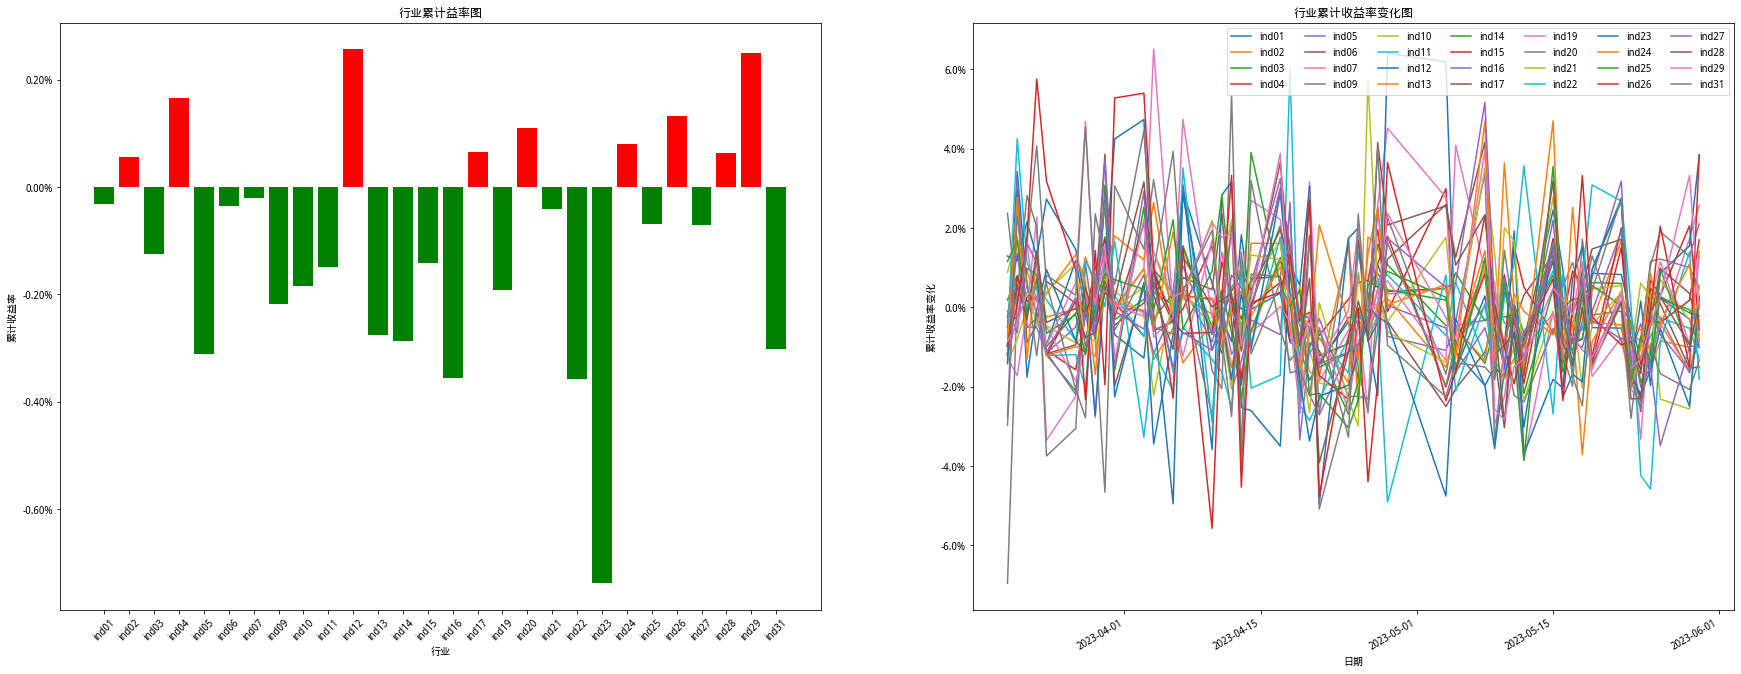

In [394]:
import matplotlib.ticker as mtick
plt.figure(figsize=(30,12))
colors = ["green" if value < 0 else "red" for value in ind_yields["Results"]]
ax=plt.subplot(121)
ax.bar(ind_yields.index, ind_yields["Results"], color = colors)
# industry.plot(kind='bar', ax=ax)
ax.set(title="行业累计益率图", xlabel='行业', ylabel='累计收益率')
ax.set_xticklabels(ind_yields.index,rotation=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

ax=plt.subplot(122)
yield_change_rate.plot(ax=ax)
# ax.plot(yield_change_rate.index, yield_change_rate["ind23"])
ax.legend(loc = "upper right", ncol = 7)
ax.set(title="行业累计收益率变化图", xlabel='日期', ylabel='累计收益率变化')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))